In [18]:
import os, random

import numpy as np
import pandas as pd
from PIL import Image, ImageOps
from tqdm import tqdm

import matplotlib.pyplot as plt

import umap

from sklearn.manifold import (
    MDS,
    TSNE,
    Isomap,
    LocallyLinearEmbedding,
    SpectralEmbedding,
)
from sklearn.ensemble import RandomTreesEmbedding


from sklearn.decomposition import PCA, KernelPCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score

import warnings
warnings.filterwarnings("ignore", category=FutureWarning, message=".*force_all_finite.*")



In [19]:
def clusters_to_files(y, names):
    clusters = {}
    for i, name in enumerate(names):
        yi = int(y[i])
        if yi not in clusters:
            clusters[yi] = []
        clusters[yi].append(name)

    # text file:

    with open('clusters.txt', 'w') as f:
        for cluster in clusters:
            for name in clusters[cluster]:
                f.write(f"{name} ")
            f.write("\n")
    
    # html file:

    with open('clusters.html', 'w') as f:
        for cluster in clusters:
            for name in clusters[cluster]:
                f.write(f"<img src='training_samples/{name}'>")
            f.write("<HR>")



def center_image_by_centroid(img):
    img = img.astype(float)
    h, w = img.shape

    # Zamiana obrazu na binarny: 1 dla pikseli > 0, 0 dla pozostałych
    binary_img = (img > 0).astype(float)

    y, x = np.indices((h, w))

    total = binary_img.sum()
    if total == 0:
        return img.copy()

    # Obliczenie centroidu na podstawie binarnego obrazu
    cx = (x * binary_img).sum() / total
    cy = (y * binary_img).sum() / total

    target_cx = w // 2
    target_cy = h // 2

    shift_x = int(round(target_cx - cx))
    shift_y = int(round(target_cy - cy))

    shifted = np.roll(img, shift=shift_y, axis=0)
    shifted = np.roll(shifted, shift=shift_x, axis=1)

    if shift_y > 0:
        shifted[:shift_y, :] = 0
    elif shift_y < 0:
        shifted[shift_y:, :] = 0

    if shift_x > 0:
        shifted[:, :shift_x] = 0
    elif shift_x < 0:
        shifted[:, shift_x:] = 0

    return shifted


def smooth_img(img: np.ndarray) -> np.ndarray:
    if img.ndim != 2:
        raise ValueError("Funkcja obsługuje tylko 2D macierze")

    # Stworzenie kopii, aby nie nadpisać oryginału
    new_img = img.copy()

    # Operacja tylko na wewnętrznych pikselach
    new_img[1:-1, 1:-1] += (
        img[2:, 1:-1] +     # img[i+1][j]
        img[:-2, 1:-1] +    # img[i-1][j]
        img[1:-1, 2:] +     # img[i][j+1]
        img[1:-1, :-2]      # img[i][j-1]
    )

    return new_img


# I transform image into a 1d array
# I also add some features that I think can be very useful:
# - width
# - height
# - the number of pixels in the image
# - number of pixels with a certaing color (0, 255)
# I also scale the image and apply dimentionality redciton
def transform_image(image, max_x, max_y):
    pad_x = max_x - image.shape[0]
    pad_y = max_y - image.shape[1]
    # pad with white pixels (0)
    # add information about the number of pixels
    extra_features = np.array([
        image.shape[0],
        image.shape[1],
        # np.sum(np.any(image > 10, axis=0))
        # image.shape[0] * image.shape[1]
        # 
    ], dtype=np.float32)

    image = np.pad(
        image,
        ((0, pad_x), (0, pad_y)),
        mode='constant',
        constant_values=0
    )

    # center image by centroid
    image = center_image_by_centroid(image)

    image = image.flatten()
    return image.astype(np.float32), extra_features

Wczytuję wszystkie training samples

In [20]:
images = []
image_names = []

for filename in os.listdir('./training_samples'):
    if filename.endswith('.png'):
        # Read the image file
        image_path = os.path.join('./training_samples', filename)
        image = Image.open(image_path).convert('L') # Convert to grayscale
        image = ImageOps.invert(image) # I want white pixels to be 0 and black pixels to be 255
        image = np.array(image)
        # image = center_image_by_centroid(image)
        images.append(np.array(image))
        image_names.append(filename)


# samples = random.sample(range(len(images)), 2000)
# images, images_names = zip(*[(images[i], image_names[i]) for i in samples])

max_x = max(image.shape[0] for image in images)
max_y = max(image.shape[1] for image in images)

X_b, X_extra = [], []
for image in images:
    x, x_extra = transform_image(image, max_x, max_y)
    X_b.append(x)
    X_extra.append(x_extra)

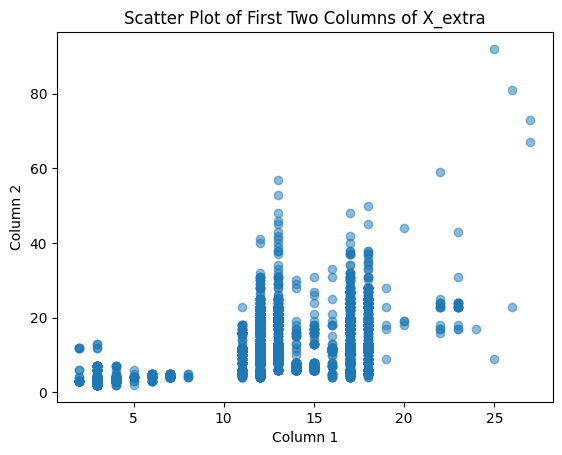

In [21]:
X_extra = np.array(X_extra)

# scaler = StandardScaler()
# X_b = scaler.fit_transform(X_b)

plt.scatter(X_extra[:, 0], X_extra[:, 1], alpha=0.5)
plt.xlabel('Column 1')
plt.ylabel('Column 2')
plt.title('Scatter Plot of First Two Columns of X_extra')
plt.show()


In [22]:
def metric_sz(X, squared=False):
    X = np.asarray(X, dtype=np.float32)
    
    l = X[:, None, :]
    lj = X[None, :, :]
    
    r = np.maximum(l, lj) / np.minimum(l, lj)
    R = np.prod(r, axis=2)
    
    return R

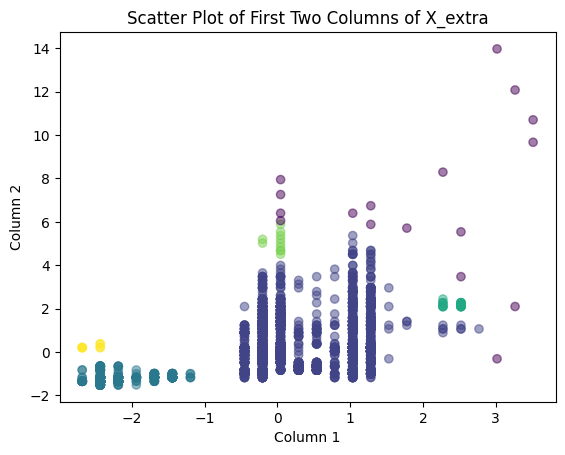

In [23]:
# Cluster only X_extra and plot
from sklearn.metrics import silhouette_samples
from collections import Counter
def silhouette_modified(X, labels):
    sil = silhouette_samples(X, labels)
    cs = Counter(labels)
    cs = Counter(labels)
    weights = np.array([cs[l] for l in labels], dtype=float)
    return (sil * weights).sum() / weights.sum()

D = metric_sz(X_extra)

sil = []

# for i in tqdm(range(3, 10)):
#     ag = AgglomerativeClustering(n_clusters=i)
#     y = ag.fit_predict(X_extra)
#     # y = ag.fit_predict(X_extra)
#     sil.append(silhouette_modified(X_extra, y))

# plt.plot(range(3, 10), sil)
# plt.xlabel('Number of clusters')
# plt.ylabel('Silhouette score')
# plt.title('Silhouette score for Agglomerative Clustering')
# plt.show()

scaler = StandardScaler()
X_extra = scaler.fit_transform(X_extra)

ag = DBSCAN()

# y = ag.fit_predict(X_extra)
y = ag.fit_predict(X_extra)
plt.scatter(X_extra[:, 0], X_extra[:, 1], c=y, alpha=0.5)
plt.xlabel('Column 1')
plt.ylabel('Column 2')
plt.title('Scatter Plot of First Two Columns of X_extra')
plt.show()
# clusters_to_files(y, image_names)

simple_clusters = [
    [image_names[i] for i in range(len(image_names)) if y[i] == j and y[i] != -1]
    for j in range(np.max(y) + 1)
]
singular_clusters = [
    [image_names[i]]
    for i in range(len(image_names)) if y[i] == -1
]

simple_clusters.extend(singular_clusters)

In [25]:
def cluster_images(img_names):
    mx_x, mx_y = 0, 0

    imgs = []
    for name in img_names:
        image_path = os.path.join('./training_samples', name)
        image = Image.open(image_path).convert('L')
        image = ImageOps.invert(image)
        image = np.array(image)
        image = center_image_by_centroid(image)
        imgs.append(image)

        mx_x = max(mx_x, image.shape[0]) 
        mx_y = max(mx_y, image.shape[1]) 

    print(mx_x, mx_y)
    print(len(imgs))

    def make_row(image):
        image = np.pad(
            image,
            ((0, mx_x - image.shape[0]), (0, mx_y - image.shape[1])),
            mode='constant',
            constant_values=0
        )
        image = center_image_by_centroid(image)
        return image.flatten()
    


    imgs = [
        make_row(image)
        for image in imgs
    ]

    X_b = np.array(imgs, dtype=np.float32)
    
    n_samples = X_b.shape[0]
    n_components = min(mx_x * mx_y, 20, n_samples - 1)

    if n_components <= 1:
        # not enough samples
        return [{
            'cluster': 0,
            'name': name
        } for name in img_names]


    tr = LocallyLinearEmbedding(
        n_components=n_components,
        n_neighbors=min(10, n_components)
    )


    X_b = tr.fit_transform(X_b)


    min_cl, max_cl = 2, min(n_samples, 80)
    sils = []

    for i in tqdm(range(min_cl, max_cl)):
        ag = KMeans(n_clusters=i, algorithm='elkan')
        y = ag.fit_predict(X_b)
        sils.append(silhouette_score(X_b, y))
    
    if max(sils) < 0:
        # all in one cluster
        return [{
            'cluster': 0,
            'name': name
        } for name in img_names]
    
    
    n_clusters = np.argmax(sils) + min_cl
    print(f"Number of clusters: {n_clusters}")
    ag = KMeans(n_clusters=n_clusters, algorithm='elkan')
    y = ag.fit_predict(X_b)
    return [{
        'cluster': y_i,
        'name': name
    } for y_i, name in zip(y, img_names) ]


y = []
names = []
cl_it = 0

# simple_clusters[0] = simple_clusters[2]

for simple_cluster in simple_clusters:
    clusters = cluster_images(simple_cluster)
    for cluster in clusters:
        y.append(cluster['cluster'] + cl_it)
        names.append(cluster['name'])
    cl_it += np.max([cluster['cluster'] for cluster in clusters]) + 1
    # break
    
clusters_to_files(y, names)

24 42
6685


100%|██████████| 78/78 [00:25<00:00,  3.10it/s]


Number of clusters: 71
8 7
879


100%|██████████| 78/78 [00:05<00:00, 14.79it/s]


Number of clusters: 29
23 25
20


100%|██████████| 18/18 [00:00<00:00, 709.22it/s]


Number of clusters: 16
13 45
11


100%|██████████| 9/9 [00:00<00:00, 870.45it/s]


Number of clusters: 4
3 13
8


100%|██████████| 6/6 [00:00<00:00, 810.89it/s]

Number of clusters: 7
23 43
1
17 48
1
18 45
1
13 46
1
22 59
1
23 31
1
25 92
1
27 67
1
13 53
1
27 73
1
13 57
1
18 50
1
20 44
1
26 23
1
26 81
1
25 9
1
13 48
1


In [ ]:
images = []
image_names = []

for filename in os.listdir('./training_samples'):
    if filename.endswith('.png'):
        # Read the image file
        image_path = os.path.join('./training_samples', filename)
        image = Image.open(image_path).convert('L') # Convert to grayscale
        image = ImageOps.invert(image) # I want white pixels to be 0 and black pixels to be 255
        images.append(np.array(image))
        image_names.append(filename)


# samples = random.sample(range(len(images)), 2000)
# images, images_names = zip(*[(images[i], image_names[i]) for i in samples])

max_x = max(image.shape[0] for image in images) + 3
max_y = max(image.shape[1] for image in images) + 3


def trim(image, max_x, max_y, pad_left, pad_top):
    pad_right = max_x - image.shape[0] - pad_left
    pad_bottom = max_y - image.shape[1] - pad_top
    # pad with white pixels (0)
    # add information about the number of pixels
    # extra_features = np.array([
    #     image.shape[0],
    #     image.shape[1],
    # ], dtype=np.float32)

    image = np.pad(
        image,
        ((pad_left, pad_right), (pad_top, pad_bottom)),
        mode='constant',
        constant_values=0
    )

    image = image.flatten()
    return image.astype(np.float32)

shft = 1

def experimental_metric(X):
    diff = X[:, None, :] - X[None, :, :]
    D = np.linalg.norm(diff, axis=2)
    N = D.shape[0] // (shft * shft) 
    D_blocks = D.reshape(N, shft * shft, N, shft * shft)
    return D_blocks.min(axis=(1, 3))

X_b = []
for image in images:
    for i in range(shft):
        for j in range(shft):
            x = trim(image, max_x, max_y, i, j)
            X_b.append(x)

X_b = np.array(X_b, dtype=np.float32)
tr = umap.UMAP(n_components=30)
X_b = tr.fit_transform(X_b)

D = experimental_metric(X_b)

sil = []

for i in tqdm(range(3, 80)):
    ag = AgglomerativeClustering(n_clusters=i, linkage='average', metric='precomputed')
    y = ag.fit_predict(D)
    # y = ag.fit_predict(X_extra)
    sil.append(silhouette_score(D, y))

plt.plot(range(3, 80), sil)
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette score')
plt.title('Silhouette score for Agglomerative Clustering')
plt.show()

ag = AgglomerativeClustering(n_clusters=np.argmax(sil) + 3, linkage='average', metric='precomputed')
y = ag.fit_predict(D)
clusters_to_files(y, image_names)

KeyboardInterrupt: 